In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import warnings
import hashlib
from sklearn.model_selection import GroupShuffleSplit
warnings.filterwarnings('ignore')

# LOADING THE DATASET

In [2]:
df = pd.read_csv("mle_screening_dataset.csv")
print(f"Dataset loaded successfully")

Dataset loaded successfully


# DATASET UNDERSTANDING

In [3]:
print(f" Initial shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

 Initial shape: (16406, 2)
Columns: ['question', 'answer']


In [4]:
df.head()

,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...
2,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...
3,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl..."


In [5]:
df.tail()

,question,answer
16401,What is (are) Diabetic Neuropathies: The Nerve...,Autonomic neuropathy affects the nerves that c...
16402,What is (are) Diabetic Neuropathies: The Nerve...,"Proximal neuropathy, sometimes called lumbosac..."
16403,What is (are) Diabetic Neuropathies: The Nerve...,Focal neuropathy appears suddenly and affects ...
16404,How to prevent Diabetic Neuropathies: The Nerv...,The best way to prevent neuropathy is to keep ...
16405,How to diagnose Diabetic Neuropathies: The Ner...,Doctors diagnose neuropathy on the basis of sy...


In [6]:
df.sample(5, random_state=0)

,question,answer
7354,What are the symptoms of Cholesteatoma ?,What symptoms are associated with cholesteatom...
6837,What is (are) Kaposi sarcoma ?,Kaposi sarcoma (KS) is a cancer that develops ...
8175,What causes Anemia ?,The three main causes of anemia are:\n ...
14532,How many people are affected by distal heredit...,The prevalence of distal hereditary motor neur...
9957,How many people are affected by REN-related ki...,REN-related kidney disease is a rare condition...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16406 entries, 0 to 16405
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  16406 non-null  object
 1   answer    16401 non-null  object
dtypes: object(2)
memory usage: 256.5+ KB


In [8]:
missing_values = df.isnull().sum()
print(missing_values)

question    0
answer      5
dtype: int64


In [9]:
df["question"] = df["question"].astype(str)
df["answer"]   = df["answer"].astype(str)

In [10]:
# Calculate lengths
df['question_length'] = df['question'].str.len()
df['answer_length'] = df['answer'].str.len()
df['question_words'] = df['question'].str.split().str.len()
df['answer_words'] = df['answer'].str.split().str.len()

In [11]:
print("Length Statistics:")
print("Questions (characters):")
print(df['question_length'].describe())
print("\nAnswers (characters):")
print(df['answer_length'].describe())
print("\nQuestions (words):")
print(df['question_words'].describe())
print("\nAnswers (words):")
print(df['answer_words'].describe())

Length Statistics:
Questions (characters):
count    16406.000000
mean        50.686639
std         16.922759
min         16.000000
25%         38.000000
50%         48.000000
75%         60.750000
max        191.000000
Name: question_length, dtype: float64

Answers (characters):
count    16406.000000
mean      1302.606059
std       1656.125617
min          3.000000
25%        486.250000
50%        889.000000
75%       1587.000000
max      29046.000000
Name: answer_length, dtype: float64

Questions (words):
count    16406.000000
mean         8.211996
std          2.380822
min          3.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         27.000000
Name: question_words, dtype: float64

Answers (words):
count    16406.000000
mean       201.221078
std        248.400738
min          1.000000
25%         71.000000
50%        138.000000
75%        252.000000
max       4281.000000
Name: answer_words, dtype: float64


In [12]:
string_nan_q = df['question'].str.lower().isin(['nan', 'none', 'null']).sum()
string_nan_a = df['answer'].str.lower().isin(['nan', 'none', 'null']).sum()
print(f"String 'nan'/'none' questions: {string_nan_q}")
print(f"String 'nan'/'none' answers: {string_nan_a}")

String 'nan'/'none' questions: 0
String 'nan'/'none' answers: 5


In [13]:
# 3. Empty strings after stripping
df['question_stripped'] = df['question'].str.strip()
df['answer_stripped'] = df['answer'].str.strip()

empty_q = (df['question_stripped'] == '').sum()
empty_a = (df['answer_stripped'] == '').sum()
print(f"Empty questions after stripping: {empty_q}")
print(f"Empty answers after stripping: {empty_a}")

Empty questions after stripping: 0
Empty answers after stripping: 0


In [14]:
# 4. Very short content
very_short_q = (df['question_length'] <= 2).sum()
very_short_a = (df['answer_length'] <= 2).sum()
print(f"Very short questions (≤2 chars): {very_short_q}")
print(f"Very short answers (≤2 chars): {very_short_a}")

Very short questions (≤2 chars): 0
Very short answers (≤2 chars): 0


# DATA CLEANING

In [15]:
# Filter out rows where either the question or the answer is invalid
mask_valid = (
    # Both question and answer must not be NaN
    (~df['question'].isna()) & (~df['answer'].isna()) &
    # Exclude strings of null values
    (~df['question'].str.lower().isin(['nan', 'none', 'null'])) &
    (~df['answer'].str.lower().isin(['nan', 'none', 'null'])) &
    # Exclude rows where text is empty after stripping spaces
    (df['question_stripped'] != '') & (df['answer_stripped'] != '') &
    # Keeping only entries longer than 2 characters
    (df['question_length'] > 2) & (df['answer_length'] > 2)
)

df_clean = df[mask_valid].copy()
removed_count = len(df) - len(df_clean)

print(f"Removed {removed_count} rows with missing, empty, or invalid text.")
print(f"Remaining rows after cleaning: {len(df_clean)}")


Removed 5 rows with missing, empty, or invalid text.
Remaining rows after cleaning: 16401


# NORMALIZING THE DATA

In [16]:
# Update our working dataframe
df = df_clean.copy()

In [17]:
print("Applying text normalization...")

# Function to normalize text
def normalize_text(text):
    if pd.isna(text):
        return text

    # Convert to string
    text = str(text)

    # Strip whitespace
    text = text.strip()

    # Replace multiple whitespaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove excessive punctuation
    text = re.sub(r'([.!?]){2,}', r'\1', text)

    return text.strip()

# Apply normalization
df['q_normalized'] = df['question'].apply(normalize_text)
df['a_normalized'] = df['answer'].apply(normalize_text)

print("✓ Text normalization completed")

Applying text normalization...
✓ Text normalization completed


In [18]:
# Show example of normalization
print("\nExamples of normalization:")
for i in range(min(3, len(df))):
    print(f"\nOriginal Q: '{df.iloc[i]['question']}'")
    print(f"Normalized: '{df.iloc[i]['q_normalized']}'")
    print(f"Original A: '{df.iloc[i]['answer']}'")
    print(f"Normalized: '{df.iloc[i]['a_normalized']}'")


Examples of normalization:

Original Q: 'What is (are) Glaucoma ?'
Normalized: 'what is (are) glaucoma ?'
Original A: 'Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. The most common form of the disease is open-angle glaucoma. With early treatment, you can often protect your eyes against serious vision loss. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.)  See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more.  See a glossary of glaucoma terms.'
Normalized: 'glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. the most common form of the disease is open-angle glaucoma. with early treatment, you can often protect your eyes against 

In [19]:
# Update main columns
df['question'] = df['q_normalized']
df['answer'] = df['a_normalized']

# DUPLICATE VALUE CHECKS

In [20]:
initial_count = len(df)

# 1. Exact duplicates (both question and answer identical)
print("Checking for exact duplicates...")
exact_duplicates = df.duplicated(subset=['question', 'answer']).sum()
print(f"Exact duplicates found: {exact_duplicates}")

Checking for exact duplicates...
Exact duplicates found: 48


In [21]:
# Check the actual duplicate rows (both question & answer identical)
dup_mask = df.duplicated(subset=['question', 'answer'], keep=False)
df_dups = df.loc[dup_mask].copy()

print(f"Exact duplicate rows (including originals): {len(df_dups)}")
print(f"Unique duplicate pairs: {df_dups[['question','answer']].drop_duplicates().shape[0]}")


Exact duplicate rows (including originals): 80
Unique duplicate pairs: 32


In [22]:
# Show a few examples (adjust n as needed)
display(df_dups.head(20))

,question,answer,question_length,answer_length,question_words,answer_words,question_stripped,answer_stripped,q_normalized,a_normalized
15239,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...,34,2215,7,340,What is (are) Causes of Diabetes ?,Diabetes is a complex group of diseases with a...,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...
15240,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...,32,6370,6,976,What causes Causes of Diabetes ?,Type 1 diabetes is caused by a lack of insulin...,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...
15241,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...,32,11317,6,1674,What causes Causes of Diabetes ?,Type 2 diabetesthe most common form of diabete...,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...
15242,what causes causes of diabetes ?,insulin resistance and beta cell dysfunction h...,32,2202,6,314,What causes Causes of Diabetes ?,Insulin Resistance and Beta Cell Dysfunction\n...,what causes causes of diabetes ?,insulin resistance and beta cell dysfunction h...
15243,what causes causes of diabetes ?,other types of diabetes have a variety of poss...,32,4747,6,673,What causes Causes of Diabetes ?,Other types of diabetes have a variety of poss...,what causes causes of diabetes ?,other types of diabetes have a variety of poss...
15244,what causes causes of diabetes ?,other types of diabetes have a variety of poss...,32,4747,6,673,What causes Causes of Diabetes ?,Other types of diabetes have a variety of poss...,what causes causes of diabetes ?,other types of diabetes have a variety of poss...
15245,what to do for causes of diabetes ?,- diabetes is a complex group of diseases with...,35,2275,8,368,What to do for Causes of Diabetes ?,- Diabetes is a complex group of diseases with...,what to do for causes of diabetes ?,- diabetes is a complex group of diseases with...
15310,what is (are) kidney failure: eat right to fee...,you already know you need to watch how much yo...,71,2310,13,384,What is (are) Kidney Failure: Eat Right to Fee...,You already know you need to watch how much yo...,what is (are) kidney failure: eat right to fee...,you already know you need to watch how much yo...
15311,what is (are) kidney failure: eat right to fee...,you already know you need to watch how much yo...,71,2310,13,384,What is (are) Kidney Failure: Eat Right to Fee...,You already know you need to watch how much yo...,what is (are) kidney failure: eat right to fee...,you already know you need to watch how much yo...
15312,what is (are) kidney failure: eat right to fee...,"potassium is a mineral found in many foods, es...",71,1877,13,274,What is (are) Kidney Failure: Eat Right to Fee...,"Potassium is a mineral found in many foods, es...",what is (are) kidney failure: eat right to fee...,"potassium is a mineral found in many foods, es..."


In [23]:
# Which pairs are duplicated the most?
dup_counts = (
    df_dups
    .value_counts(subset=['question', 'answer'])
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)
print("Top duplicate pairs:")
display(dup_counts.head(10))

Top duplicate pairs:


,question,answer,count
0,what causes causes of diabetes ?,other types of diabetes have a variety of poss...,8
1,what causes causes of diabetes ?,insulin resistance and beta cell dysfunction h...,4
2,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...,4
3,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...,4
4,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...,4
5,what to do for causes of diabetes ?,- diabetes is a complex group of diseases with...,4
6,how to diagnose renal tubular acidosis ?,"to diagnose rta, doctors check the acid-base b...",2
7,how to diagnose glomerular diseases ?,patients with glomerular disease have signific...,2
8,what are the treatments for hypoglycemia ?,signs and symptoms of hypoglycemia vary from p...,2
9,what are the treatments for acromegaly ?,"currently, treatment options include surgical ...",2


In [24]:
# Tag groups to review visually
key = df_dups['question'].astype(str) + "␞" + df_dups['answer'].astype(str)
df_dups['dup_group_id'] = pd.factorize(key)[0]
df_dups = df_dups.sort_values(['dup_group_id']).reset_index(drop=True)

# First few groups side-by-side
print("Sample of duplicate groups:")
display(
    df_dups
    .groupby('dup_group_id', group_keys=False)
    .head(3)  # show up to 3 rows per group
    .head(10) # limit overall preview
)

Sample of duplicate groups:


,question,answer,question_length,answer_length,question_words,answer_words,question_stripped,answer_stripped,q_normalized,a_normalized,dup_group_id
0,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...,34,2215,7,340,What is (are) Causes of Diabetes ?,Diabetes is a complex group of diseases with a...,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...,0
1,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...,34,2215,7,340,What is (are) Causes of Diabetes ?,Diabetes is a complex group of diseases with a...,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...,0
2,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...,34,2215,7,340,What is (are) Causes of Diabetes ?,Diabetes is a complex group of diseases with a...,what is (are) causes of diabetes ?,diabetes is a complex group of diseases with a...,0
4,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...,32,6370,6,976,What causes Causes of Diabetes ?,Type 1 diabetes is caused by a lack of insulin...,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...,1
5,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...,32,6370,6,976,What causes Causes of Diabetes ?,Type 1 diabetes is caused by a lack of insulin...,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...,1
6,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...,32,6370,6,976,What causes Causes of Diabetes ?,Type 1 diabetes is caused by a lack of insulin...,what causes causes of diabetes ?,type 1 diabetes is caused by a lack of insulin...,1
8,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...,32,11317,6,1674,What causes Causes of Diabetes ?,Type 2 diabetesthe most common form of diabete...,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...,2
9,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...,32,11317,6,1674,What causes Causes of Diabetes ?,Type 2 diabetesthe most common form of diabete...,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...,2
10,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...,32,11317,6,1674,What causes Causes of Diabetes ?,Type 2 diabetesthe most common form of diabete...,what causes causes of diabetes ?,type 2 diabetesthe most common form of diabete...,2
12,what causes causes of diabetes ?,insulin resistance and beta cell dysfunction h...,32,2202,6,314,What causes Causes of Diabetes ?,Insulin Resistance and Beta Cell Dysfunction\n...,what causes causes of diabetes ?,insulin resistance and beta cell dysfunction h...,3


In [25]:
# Removing exact duplicates (keep the first occurrence):
df_nodup = df.drop_duplicates(subset=['question', 'answer'], keep='first').copy()
removed_exact = len(df) - len(df_nodup)
print(f"Removed {removed_exact} exact duplicate rows.")
print(f"Rows after removing exact duplicates: {len(df_nodup)}")

Removed 48 exact duplicate rows.
Rows after removing exact duplicates: 16353


In [26]:
# Update our working dataframe
df = df_nodup.copy()

In [27]:
df

,question,answer,question_length,answer_length,question_words,answer_words,question_stripped,answer_stripped,q_normalized,a_normalized
0,what is (are) glaucoma ?,glaucoma is a group of diseases that can damag...,24,632,5,111,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,what is (are) glaucoma ?,glaucoma is a group of diseases that can damag...
1,what is (are) glaucoma ?,the optic nerve is a bundle of more than 1 mil...,24,101,5,20,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...,what is (are) glaucoma ?,the optic nerve is a bundle of more than 1 mil...
2,what is (are) glaucoma ?,open-angle glaucoma is the most common form of...,24,508,5,88,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...,what is (are) glaucoma ?,open-angle glaucoma is the most common form of...
3,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...,30,493,7,81,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...
4,how to prevent glaucoma ?,"at this time, we do not know how to prevent gl...",25,467,5,84,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl...",how to prevent glaucoma ?,"at this time, we do not know how to prevent gl..."
...,...,...,...,...,...,...,...,...,...,...
16401,what is (are) diabetic neuropathies: the nerve...,autonomic neuropathy affects the nerves that c...,67,3443,11,492,What is (are) Diabetic Neuropathies: The Nerve...,Autonomic neuropathy affects the nerves that c...,what is (are) diabetic neuropathies: the nerve...,autonomic neuropathy affects the nerves that c...
16402,what is (are) diabetic neuropathies: the nerve...,"proximal neuropathy, sometimes called lumbosac...",67,561,11,91,What is (are) Diabetic Neuropathies: The Nerve...,"Proximal neuropathy, sometimes called lumbosac...",what is (are) diabetic neuropathies: the nerve...,"proximal neuropathy, sometimes called lumbosac..."
16403,what is (are) diabetic neuropathies: the nerve...,focal neuropathy appears suddenly and affects ...,67,1120,11,188,What is (are) Diabetic Neuropathies: The Nerve...,Focal neuropathy appears suddenly and affects ...,what is (are) diabetic neuropathies: the nerve...,focal neuropathy appears suddenly and affects ...
16404,how to prevent diabetic neuropathies: the nerv...,the best way to prevent neuropathy is to keep ...,68,183,11,30,How to prevent Diabetic Neuropathies: The Nerv...,The best way to prevent neuropathy is to keep ...,how to prevent diabetic neuropathies: the nerv...,the best way to prevent neuropathy is to keep ...


## CONTENT QUALITY CHECKS

In [28]:
# 1. Questions that don't look like questions
print("Checking question format")

q_indi = r'\b(what|where|when|why|how|who|which|can|could|would|should|is|are|do|does|did|will|shall)\b'
q_with_indi = df['question'].str.contains(q_indi, case=False, na=False).sum()
q_with_quest_marks = df['question'].str.contains(r'\?', na=False).sum()

total_good_q = df[
    (df['question'].str.contains(q_indi, case=False, na=False)) |
    (df['question'].str.contains(r'\?', na=False))
].shape[0]

print(f"Questions with question words: {q_with_indi}")
print(f"Questions with question marks: {q_with_quest_marks}")
print(f"Questions that look like questions: {total_good_q} ({total_good_q/len(df)*100:.1f}%)")

Checking question format
Questions with question words: 16353
Questions with question marks: 16056
Questions that look like questions: 16353 (100.0%)


In [29]:
# Answers that look like questions
print("\n Checking for answers that look like questions")
a_with_q = df['answer'].str.contains(r'\?', na=False).sum()
print(f"No. of answers with question marks: {a_with_q} ({a_with_q/len(df)*100:.1f}%)")

if a_with_q > 0:
    ans_ques = df[df['answer'].str.contains(r'\?', na=False)]
    print("Examples of answers with question marks:")
    for i in range(min(3, len(ans_ques))):
        print(f"  Q: '{ans_ques.iloc[i]['question']}'")
        print(f"  A: '{ans_ques.iloc[i]['answer']}'")


 Checking for answers that look like questions
No. of answers with question marks: 4240 (25.9%)
Examples of answers with question marks:
  Q: 'what is (are) high blood pressure ?'
  A: 'high blood pressure is a common disease in which blood flows through blood vessels (arteries) at higher than normal pressures. what is blood pressure? blood pressure is the force of blood pushing against the walls of the blood vessels as the heart pumps blood. if your blood pressure rises and stays high over time, its called high blood pressure. high blood pressure is dangerous because it makes the heart work too hard, and the high force of the blood flow can harm arteries and organs such as the heart, kidneys, brain, and eyes. types of high blood pressure there are two main types of high blood pressure: primary and secondary high blood pressure. - primary, or essential, high blood pressure is the most common type of high blood pressure. this type of high blood pressure tends to develop over years as a

In [30]:
# 3. Identical questions and answers
print("\n Checking for identical questions and answers")
identical_qa = df[df['question'] == df['answer']]
print(f"Identical question-answer pairs: {len(identical_qa)}")

if len(identical_qa) > 0:
    print("Examples of identical Q&A pairs:")
    for i in range(min(3, len(identical_qa))):
        print(f"  '{identical_qa.iloc[i]['question']}'")


 Checking for identical questions and answers
Identical question-answer pairs: 0


In [31]:
# Check character distribution
def analyze_character_distribution(text_series, name):
    print(f"\nCharacter distribution for {name}:")
    all_text = ' '.join(text_series.astype(str))
    char_counts = Counter(all_text.lower())
    total_chars = sum(char_counts.values())

    alphabetic = sum(count for char, count in char_counts.items() if char.isalpha())
    numeric = sum(count for char, count in char_counts.items() if char.isdigit())
    punctuation = sum(count for char, count in char_counts.items() if char in string.punctuation)
    whitespace = sum(count for char, count in char_counts.items() if char.isspace())

    print(f"  Alphabetic: {alphabetic/total_chars:.3f}")
    print(f"  Numeric: {numeric/total_chars:.3f}")
    print(f"  Punctuation: {punctuation/total_chars:.3f}")
    print(f"  Whitespace: {whitespace/total_chars:.3f}")

analyze_character_distribution(df['question'], 'Questions')
analyze_character_distribution(df['answer'], 'Answers')


Character distribution for Questions:
  Alphabetic: 0.802
  Numeric: 0.003
  Punctuation: 0.036
  Whitespace: 0.159

Character distribution for Answers:
  Alphabetic: 0.810
  Numeric: 0.005
  Punctuation: 0.026
  Whitespace: 0.159


# STATISTICAL ANALYSIS

In [32]:
# Length statistics after cleaning
print("Final length statistics:")
print("\nQuestion lengths (words):")
print(df['question_words'].describe())
print("\nAnswer lengths (words):")
print(df['answer_words'].describe())

Final length statistics:

Question lengths (words):
count    16353.00000
mean         8.21464
std          2.38057
min          3.00000
25%          6.00000
50%          8.00000
75%         10.00000
max         27.00000
Name: question_words, dtype: float64

Answer lengths (words):
count    16353.000000
mean       200.293769
std        246.805755
min          1.000000
25%         71.000000
50%        138.000000
75%        251.000000
max       4281.000000
Name: answer_words, dtype: float64


In [33]:
# Question type analysis
print("\nQuestion type analysis:")
question_types = {
    'what': df['question'].str.contains(r'\bwhat\b', case=False, na=False).sum(),
    'how': df['question'].str.contains(r'\bhow\b', case=False, na=False).sum(),
    'why': df['question'].str.contains(r'\bwhy\b', case=False, na=False).sum(),
    'where': df['question'].str.contains(r'\bwhere\b', case=False, na=False).sum(),
    'when': df['question'].str.contains(r'\bwhen\b', case=False, na=False).sum(),
    'who': df['question'].str.contains(r'\bwho\b', case=False, na=False).sum(),
    'which': df['question'].str.contains(r'\bwhich\b', case=False, na=False).sum(),
    'yes_no': df['question'].str.contains(r'\b(is|are|do|does|did|can|could|would|should|will)\b', case=False, na=False).sum()
}

for q_type, count in question_types.items():
    percentage = count / len(df) * 100
    print(f"  {q_type.title()} questions: {count} ({percentage:.1f}%)")


Question type analysis:
  What questions: 12339 (75.5%)
  How questions: 1990 (12.2%)
  Why questions: 0 (0.0%)
  Where questions: 1 (0.0%)
  When questions: 0 (0.0%)
  Who questions: 322 (2.0%)
  Which questions: 0 (0.0%)
  Yes_No questions: 14799 (90.5%)


In [34]:
# Vocabulary diversity
def calculate_vocabulary_diversity(text_series, name):
    all_words = ' '.join(text_series.astype(str)).lower().split()
    unique_words = set(all_words)
    diversity = len(unique_words) / len(all_words) if all_words else 0

    print(f"\n{name} vocabulary:")
    print(f"  Total words: {len(all_words):,}")
    print(f"  Unique words: {len(unique_words):,}")
    print(f"  Diversity ratio: {diversity:.3f}")

    return diversity

q_diversity = calculate_vocabulary_diversity(df['question'], 'Question')
a_diversity = calculate_vocabulary_diversity(df['answer'], 'Answer')


Question vocabulary:
  Total words: 134,334
  Unique words: 5,087
  Diversity ratio: 0.038

Answer vocabulary:
  Total words: 3,275,404
  Unique words: 65,199
  Diversity ratio: 0.020


In [35]:
# Create visualizations
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

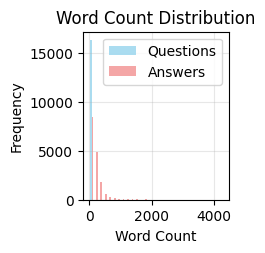

In [36]:
# 1. Length distribution
plt.subplot(2, 3, 1)
plt.hist([df['question_words'], df['answer_words']], bins=30, alpha=0.7,
         label=['Questions', 'Answers'], color=['skyblue', 'lightcoral'])
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

Text(0, 0.5, 'Count')

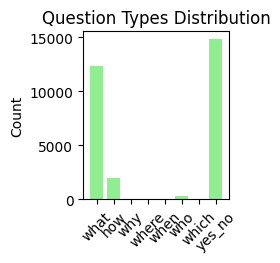

In [37]:
# 2. Question types
plt.subplot(2, 3, 2)
types = list(question_types.keys())
counts = list(question_types.values())
plt.bar(types, counts, color='lightgreen')
plt.title('Question Types Distribution')
plt.xticks(rotation=45)
plt.ylabel('Count')

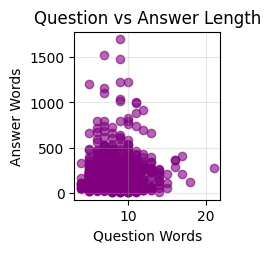

In [38]:
# 3. Length relationship
plt.subplot(2, 3, 3)
sample_size = min(1000, len(df))
sample_df = df.sample(n=sample_size) if len(df) > sample_size else df
plt.scatter(sample_df['question_words'], sample_df['answer_words'], alpha=0.6, color='purple')
plt.xlabel('Question Words')
plt.ylabel('Answer Words')
plt.title('Question vs Answer Length')
plt.grid(True, alpha=0.3)

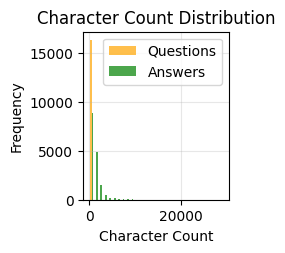

In [39]:
# 4. Character length distribution
plt.subplot(2, 3, 4)
plt.hist([df['question_length'], df['answer_length']], bins=30, alpha=0.7,
         label=['Questions', 'Answers'], color=['orange', 'green'])
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Count Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

Text(0, 0.5, 'Values (normalized)')

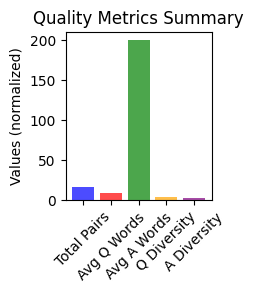

In [40]:
# 6. Quality metrics
plt.subplot(2, 3, 6)
quality_metrics = ['Total Pairs', 'Avg Q Words', 'Avg A Words', 'Q Diversity', 'A Diversity']
quality_values = [len(df)/1000, df['question_words'].mean(), df['answer_words'].mean(),
                 q_diversity*100, a_diversity*100]
colors = ['blue', 'red', 'green', 'orange', 'purple']

bars = plt.bar(range(len(quality_metrics)), quality_values, color=colors, alpha=0.7)
plt.title('Quality Metrics Summary')
plt.xticks(range(len(quality_metrics)), quality_metrics, rotation=45)
plt.ylabel('Values (normalized)')

In [41]:
# Remove temporary columns
columns_to_keep = ['question', 'answer']
df_final = df[columns_to_keep].copy()

# Final statistics
print("PREPROCESSING SUMMARY")
print("=" * 40)
print(f"Original dataset size: {initial_count}")
print(f"Final dataset size: {len(df_final)}")
print(f"Rows removed: {initial_count - len(df_final)} ({(initial_count - len(df_final))/initial_count*100:.1f}%)")
print()
print("Final dataset characteristics:")
print(f"  Average question length: {df_final['question'].str.split().str.len().mean():.1f} words")
print(f"  Average answer length: {df_final['answer'].str.split().str.len().mean():.1f} words")
print(f"  Unique questions: {df_final['question'].nunique():,}")
print(f"  Unique answers: {df_final['answer'].nunique():,}")

PREPROCESSING SUMMARY
Original dataset size: 16401
Final dataset size: 16353
Rows removed: 48 (0.3%)

Final dataset characteristics:
  Average question length: 8.2 words
  Average answer length: 200.3 words
  Unique questions: 14,342
  Unique answers: 15,803


In [42]:
# Check for non-ASCII characters
non_ascii_q = df['question'].str.contains(r'[^\x00-\x7F]', na=False).sum()
non_ascii_a = df['answer'].str.contains(r'[^\x00-\x7F]', na=False).sum()

print(f"Questions with non-ASCII characters: {non_ascii_q} ({non_ascii_q/len(df)*100:.1f}%)")
print(f"Answers with non-ASCII characters: {non_ascii_a} ({non_ascii_a/len(df)*100:.1f}%)")


Questions with non-ASCII characters: 0 (0.0%)
Answers with non-ASCII characters: 61 (0.4%)


In [43]:
amb = df.groupby('question')['answer'].nunique()
amb_rate = (amb > 1).mean()
print(f"Ambiguous question rate: {amb_rate:.1%}")

Ambiguous question rate: 9.7%


In [44]:
df=df_final.copy()

In [45]:
ques = df['question']
df['group_id'] = ques.apply(lambda s: hashlib.md5(s.encode('utf-8')).hexdigest())


In [46]:
df.head(5)

,question,answer,group_id
0,what is (are) glaucoma ?,glaucoma is a group of diseases that can damag...,59f13cf1f0ac0acb250d8241a8a93ca4
1,what is (are) glaucoma ?,the optic nerve is a bundle of more than 1 mil...,59f13cf1f0ac0acb250d8241a8a93ca4
2,what is (are) glaucoma ?,open-angle glaucoma is the most common form of...,59f13cf1f0ac0acb250d8241a8a93ca4
3,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...,a3f98d1c8346c7634563d38db5b38441
4,how to prevent glaucoma ?,"at this time, we do not know how to prevent gl...",bc39a063af4304dd880ea1721cb4b2e9


In [47]:
# Split using GroupShuffleSplit to ensure same/similar questions stay in same split
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(gss1.split(df, groups=df['group_id']))

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
test_idx, val_idx = next(gss2.split(df.iloc[temp_idx], groups=df.iloc[temp_idx]['group_id']))

train, test, val = df.iloc[train_idx], df.iloc[temp_idx[test_idx]], df.iloc[temp_idx[val_idx]]

In [48]:
# Identify ambiguous questions (>1 unique answer per question group)
answer_counts = train.groupby('group_id')['answer'].nunique()
ambiguous_groups = answer_counts[answer_counts > 1].index

In [49]:
# Remove ambiguous questions from training
train_unambiguous = train[~train['group_id'].isin(ambiguous_groups)].copy()

In [50]:
# Move ambiguous training questions to validation/test for evaluation
ambiguous_train_data = train[train['group_id'].isin(ambiguous_groups)].copy()
val_multi = pd.concat([val, ambiguous_train_data]).reset_index(drop=True)
test_multi = test.copy()

In [51]:
#Clean up datasets - remove the helper column
train_final = train_unambiguous.drop('group_id', axis=1).reset_index(drop=True)
val_final = val_multi.drop('group_id', axis=1).reset_index(drop=True)
test_final = test_multi.drop('group_id', axis=1).reset_index(drop=True)

In [52]:
 #Generate CSV files
train_final.to_csv('train.csv', index=False)
val_final.to_csv('valid.csv', index=False)
test_final.to_csv('test.csv', index=False)

In [53]:
# Print statistics
print(f"Original dataset: {len(df)} rows")
print(f"Training set: {len(train_final)} rows (unambiguous questions only)")
print(f"Validation set: {len(val_final)} rows (includes ambiguous questions from training)")
print(f"Test set: {len(test_final)} rows")
print(f"Total: {len(train_final) + len(val_final) + len(test_final)} rows")

print(f"\nAmbiguous questions moved from training to validation: {len(ambiguous_train_data)}")
print(f"Unique question groups in training: {train_final.groupby(train_unambiguous['group_id'].values).ngroups}")

Original dataset: 16353 rows
Training set: 9061 rows (unambiguous questions only)
Validation set: 4872 rows (includes ambiguous questions from training)
Test set: 2420 rows
Total: 16353 rows

Ambiguous questions moved from training to validation: 2423
Unique question groups in training: 9061
